In [24]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# OpenCV for image processing
import cv2

# PyTorch and torchvision
import torch
from torchvision import transforms

# PIL for image handling
from PIL import Image

# For dataset splitting and progress tracking
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# For XML parsing (if needed for annotations)
import xml.etree.ElementTree as ET


In [25]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fruit-images-for-object-detection/train_zip/train/banana_68.jpg
/kaggle/input/fruit-images-for-object-detection/train_zip/train/apple_46.jpg
/kaggle/input/fruit-images-for-object-detection/train_zip/train/apple_28.xml
/kaggle/input/fruit-images-for-object-detection/train_zip/train/orange_20.jpg
/kaggle/input/fruit-images-for-object-detection/train_zip/train/orange_22.xml
/kaggle/input/fruit-images-for-object-detection/train_zip/train/apple_65.xml
/kaggle/input/fruit-images-for-object-detection/train_zip/train/orange_41.xml
/kaggle/input/fruit-images-for-object-detection/train_zip/train/banana_67.xml
/kaggle/input/fruit-images-for-object-detection/train_zip/train/mixed_12.xml
/kaggle/input/fruit-images-for-object-detection/train_zip/train/banana_37.xml
/kaggle/input/fruit-images-for-object-detection/train_zip/train/mixed_1.jpg
/kaggle/input/fruit-images-for-object-detection/train_zip/train/apple_55.xml
/kaggle/input/fruit-images-for-object-detection/train_zip/train/mixed_2

**Since It has XML Files that has annotations of each image (Bounding Boxes)**


In [26]:

# Define paths
train_path = '/kaggle/input/fruit-images-for-object-detection/train_zip/train/'
test_path = '/kaggle/input/fruit-images-for-object-detection/test_zip/test/'


# Function to parse XML files and gather data
def gather_data_to_csv(train_path):
    data = []
    
    for file in os.listdir(train_path):
        if file.endswith('.xml'):
            xml_file_path = os.path.join(train_path, file)
            tree = ET.parse(xml_file_path)
            root = tree.getroot()
            
            # Get the corresponding image file name
            image_file_name = file.replace('.xml', '.jpg')  # Assuming JPG format
            
            for member in root.findall('object'):
                value = {
                    'image': image_file_name,
                    'class': member.find('name').text,
                    'xmin': int(member.find('bndbox/xmin').text),
                    'ymin': int(member.find('bndbox/ymin').text),
                    'xmax': int(member.find('bndbox/xmax').text),
                    'ymax': int(member.find('bndbox/ymax').text)
                }
                data.append(value)

    return pd.DataFrame(data)

# Gather data and create DataFrame
train_df = gather_data_to_csv(train_path)
test_df = gather_data_to_csv(test_path)

# Save DataFrame to CSV
train_file_path = '/kaggle/working/fruits_data_train.csv'  # Specify your desired output path
train_df.to_csv(train_file_path, index=False)
test_file_path = '/kaggle/working/fruits_data_test.csv'  # Specify your desired output path
test_df.to_csv(test_file_path, index=False)

# Display the first few rows of the DataFrame
print(train_df.head())
print(test_df.head())



           image   class  xmin  ymin  xmax  ymax
0   apple_28.jpg   apple    25    42   275   297
1  orange_22.jpg  orange    75    96   531   465
2   apple_65.jpg   apple    70    25   290   226
3   apple_65.jpg   apple    35   217   253   453
4   apple_65.jpg   apple   183   177   382   411
           image   class  xmin  ymin  xmax  ymax
0  banana_84.jpg  banana    85   138   553   352
1  orange_77.jpg  orange     1   123   130   299
2  orange_77.jpg  orange   379     1   558   144
3  banana_77.jpg  banana    29    11   246   348
4   apple_82.jpg   apple    65   122   365   404


In [27]:

# Load the CSV file
csv_file_path = '/kaggle/working/fruits_data_train.csv'  # Adjust the path as needed
data = pd.read_csv(csv_file_path)

# Display the first few rows
print(data.head())


           image   class  xmin  ymin  xmax  ymax
0   apple_28.jpg   apple    25    42   275   297
1  orange_22.jpg  orange    75    96   531   465
2   apple_65.jpg   apple    70    25   290   226
3   apple_65.jpg   apple    35   217   253   453
4   apple_65.jpg   apple   183   177   382   411


# EDA

class
banana    169
apple     156
orange    140
Name: count, dtype: int64


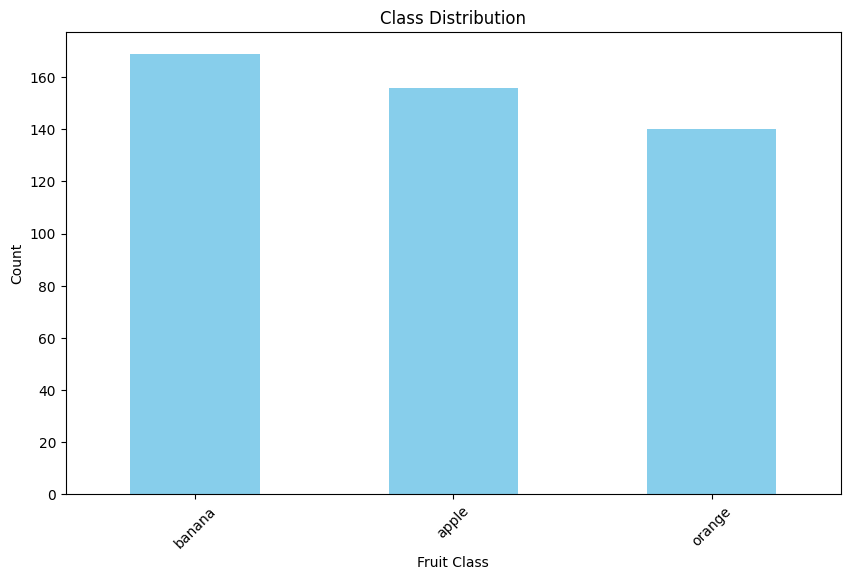

In [28]:
# Class distribution
class_distribution = data['class'].value_counts()

# Display class distribution
print(class_distribution)

# Plot class distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Fruit Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [29]:
# Number of unique classes
num_classes = data['class'].nunique()
print(f'Number of unique classes: {num_classes}')


Number of unique classes: 3


             width      height
class                         
apple   292.455128  293.012821
banana  526.769231  378.313609
orange  331.978571  323.442857


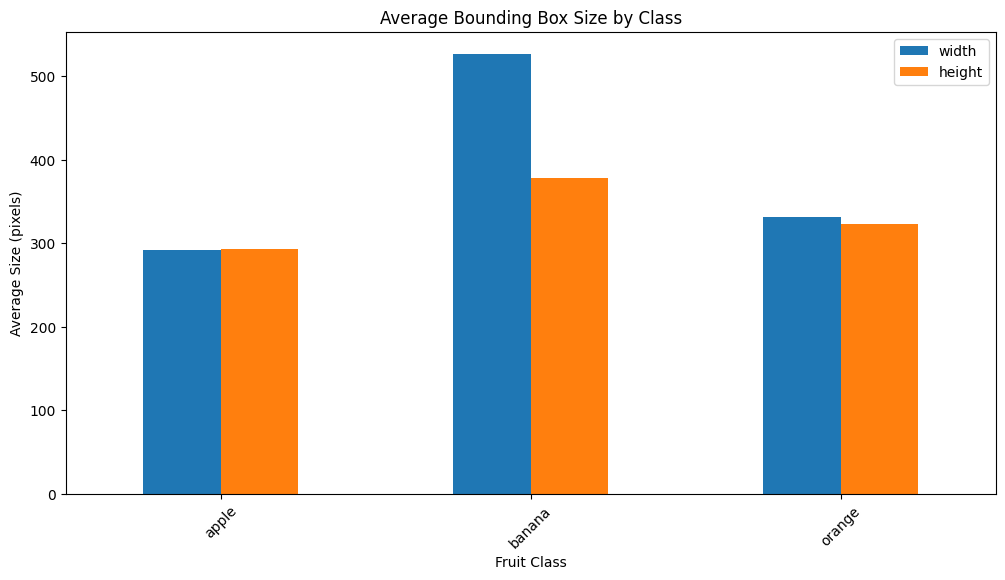

In [30]:
# Calculate bounding box sizes
data['width'] = data['xmax'] - data['xmin']
data['height'] = data['ymax'] - data['ymin']

# Average bounding box size by class
avg_bbox_size = data.groupby('class')[['width', 'height']].mean()

# Display average bounding box sizes
print(avg_bbox_size)

# Plot average bounding box sizes
avg_bbox_size.plot(kind='bar', figsize=(12, 6))
plt.title('Average Bounding Box Size by Class')
plt.xlabel('Fruit Class')
plt.ylabel('Average Size (pixels)')
plt.xticks(rotation=45)
plt.show()


In [31]:
train_df = pd.read_csv('/kaggle/working/fruits_data_train.csv')
test_df = pd.read_csv('/kaggle/working/fruits_data_test.csv')

# Define the path to images
train_img_path = '/kaggle/input/fruit-images-for-object-detection/train_zip/train/'
test_img_path = '/kaggle/input/fruit-images-for-object-detection/test_zip/test/'

# Sample check
train_df.head()


,image,class,xmin,ymin,xmax,ymax
0,apple_28.jpg,apple,25,42,275,297
1,orange_22.jpg,orange,75,96,531,465
2,apple_65.jpg,apple,70,25,290,226
3,apple_65.jpg,apple,35,217,253,453
4,apple_65.jpg,apple,183,177,382,411


# Preprocessing 

In [32]:
# Define preprocessing functions
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    
    # Resize to 640x640 (YOLOv5 default)
    image = cv2.resize(image, (640, 640))
    
    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Normalize [0,1]
    image = image / 255.0

    return image

def augment_image(image):
    flip = cv2.flip(image, 1)  # Horizontal flip
    blur = cv2.GaussianBlur(image, (5, 5), 0)
    return flip, blur


libpng warning: iCCP: known incorrect sRGB profile


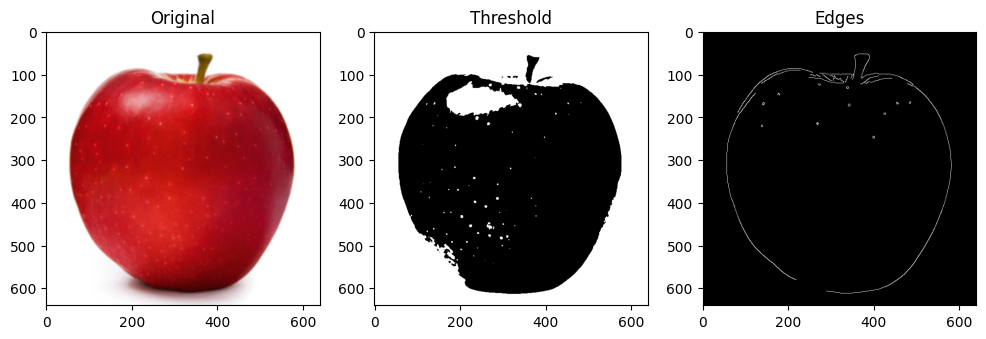

In [33]:
def segment_image(image):
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    # Thresholding
    _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
    
    # Canny edges
    edges = cv2.Canny(gray, 100, 200)

    return thresh, edges

# Test example
sample_img = preprocess_image(train_img_path + train_df.iloc[0]['image'])
thresh, edges = segment_image(sample_img)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(sample_img); plt.title('Original')
plt.subplot(1,3,2); plt.imshow(thresh, cmap='gray'); plt.title('Threshold')
plt.subplot(1,3,3); plt.imshow(edges, cmap='gray'); plt.title('Edges')
plt.show()


In [34]:
def extract_features(image):
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    mean = np.mean(gray)
    std = np.std(gray)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges) / (edges.shape[0] * edges.shape[1])
    return [mean, std, edge_density]

# Example
features = extract_features(sample_img)
print("Extracted Features:", features)


Extracted Features: [154.20506591796874, 91.08827372165081, 1.73009033203125]


# Expected Result 

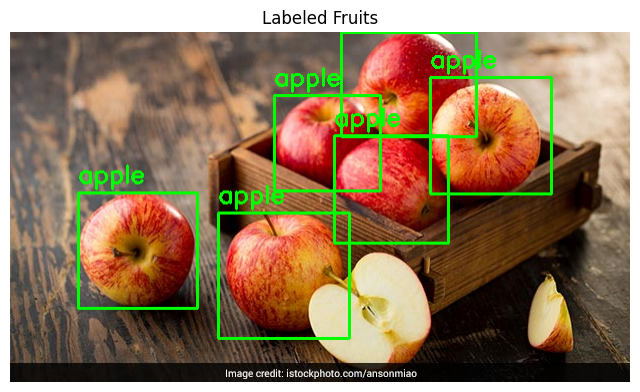

In [35]:
df = pd.read_csv("/kaggle/working/fruits_data_train.csv")

# Pick a sample image from the CSV
sample_image_name = "apple_5.jpg"
image_path = f"/kaggle/input/fruit-images-for-object-detection/train_zip/train/{sample_image_name}"

# Load the image
image = cv2.imread(image_path)

rows = df[df['image'] == sample_image_name]

# Draw boxes
for _, row in rows.iterrows():
    xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
    label = row['class']
    
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot with matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Labeled Fruits")
plt.show()
